In [31]:
import numpy as np
import faiss
import time
from tqdm import tqdm

# Our modules
import image_transformations as it
import testing_imagenet as ti
import evaluating_ann as evann

In [2]:
# Our multimodal ANN methods class
from multimodal_ann import MultimodalANN
mm_ann = MultimodalANN()
methods_list = mm_ann.methods_list

In [3]:
# Our auxiliarry class for embedding methods
from embedding_functions import EmbeddingFunctions
emb_funcs = EmbeddingFunctions()
embedding_functions = emb_funcs.embedding_functions

## quick test functioning of funcations

### sample random data for debugging

In [5]:
# Generate sample data
num_entries = 10
num_queries = 1
dims = [1]  # Example dimensions for different embedding types

# Create sample database entries
database = [
    [np.random.random((dims[i],)).astype('float32') for i in range(len(dims))]
    for _ in range(num_entries)
]

# Create sample queries
queries = [
    [np.random.random((dims[i],)).astype('float32') for i in range(len(dims))]
    for _ in range(num_queries)
]

#need to start learning wrappers that need class_ids
class_ids=[1,1,1,2,2,3,3,4,4,4]
methods_list["learn_class_weights"] = mm_ann.wrapper_learn_class_weights(class_ids)

Note: we wanted to do more types of ANNs but where limited by under the hood implementation in zig of faiss

In [6]:
index = faiss.IndexHNSWFlat(sum(dims), 2)
index.hnsw.efConstruction = 3
index.hnsw.efSearch = 2
concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in database])
        for i in range(len(dims))
    ]).astype('float32')
index.add(concatenated_data)
print(type(index.hnsw.neighbors)) # couldn't open it
#print(dir(index.hnsw.neighbors))
print([index.hnsw.neighbors])
print([index.hnsw.neighbors.at(i) for i in range(index.hnsw.neighbors.size())])
print("no clue how to use this or change its values, documentations didnt help")

<class 'faiss.swigfaiss.Int32Vector'>
[<faiss.swigfaiss.Int32Vector; proxy of <Swig Object of type 'std::vector< int > *' at 0x000001C64B40D140> >]
[8, 1, -1, -1, 8, 1, 1, 7, 1, -1, 0, 7, 8, -1, 0, -1, 0, -1, 0, -1, 4, 7, 9, -1, 8, 5, -1, -1, 6, 7, -1, -1, 6, 3, -1, -1, 3, 4, 5, -1, 4, 9, -1, -1, 8, 9, 0, -1, 3, 0, 5, -1, 7, 0, 2, 7, -1, -1, 7, -1]
no clue how to use this or change its values, documentations didnt help


### Quick test to debug

In [7]:
# Test all methods
for method_name, method in methods_list.items():
    print(f"\nTesting {method_name}")
    if True:
        print(method_name, method)
        search_fn = method(database)
        distances, indices = search_fn(queries[0])
        
        print(f"Top 5 results for first query:")
        for i in range(1):
            print(f"  Index: {indices[0][i]}, Distance: {distances[0][i]:.4f}")



Testing hnsw_simple_concatenation
hnsw_simple_concatenation <function MultimodalANN.hnsw_simple_concatenation_ann at 0x000001C64B40A160>
Top 5 results for first query:
  Index: 7, Distance: 0.0001

Testing LSH_simple_concatenation
LSH_simple_concatenation <function MultimodalANN.lsh_simple_concatenation_ann at 0x000001C64B40A200>
Top 5 results for first query:
  Index: 0, Distance: 0.0000

Testing separate indexing
separate indexing <function MultimodalANN.multi_index_ann at 0x000001C64B40A2A0>
Top 5 results for first query:
  Index: 7, Distance: 0.0075

Testing Split LSH
Split LSH <function MultimodalANN.split_lsh_ann at 0x000001C64B40A340>
Top 5 results for first query:
  Index: 0, Distance: 0.0000

Testing just norm
just norm <function MultimodalANN.just_norm_ann at 0x000001C64B40A3E0>
Top 5 results for first query:
  Index: 7, Distance: 0.0000

Testing Normalized and Scaled
Normalized and Scaled <function MultimodalANN.normalized_scaled_ann at 0x000001C64B40A480>
Top 5 results for

## Testing embedding with small dataset CIFAR100

### visualize the data set and the transformation

Files already downloaded and verified


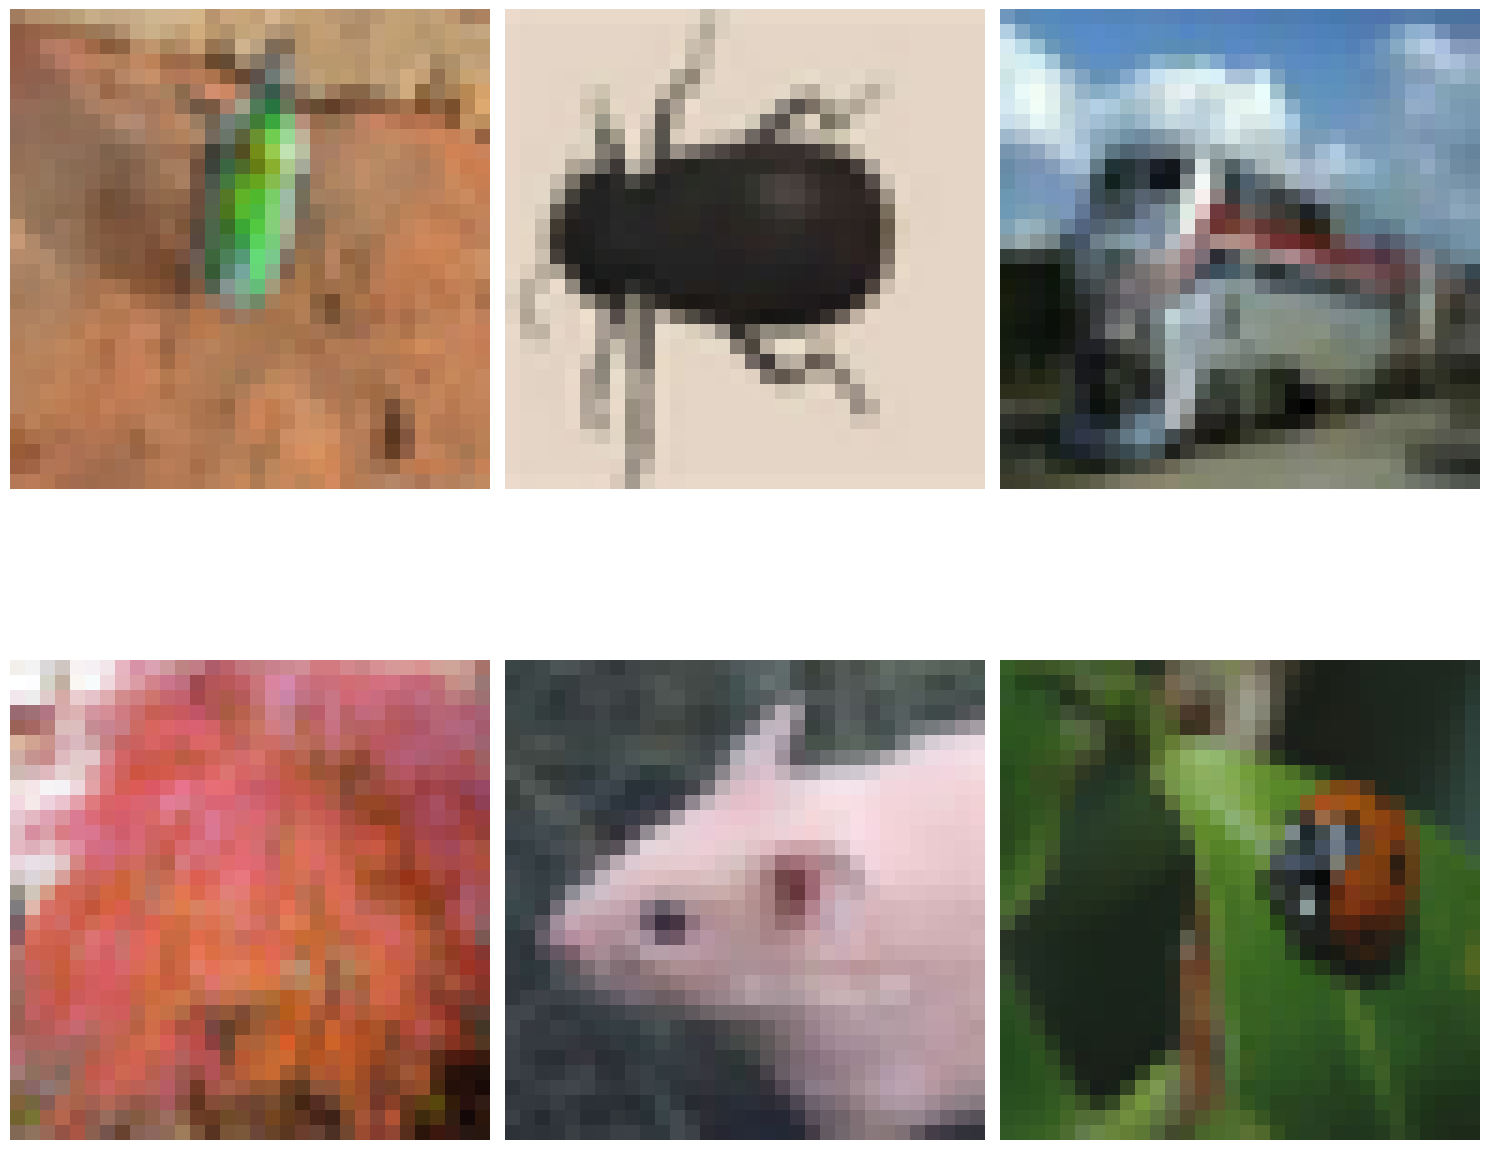

rotation


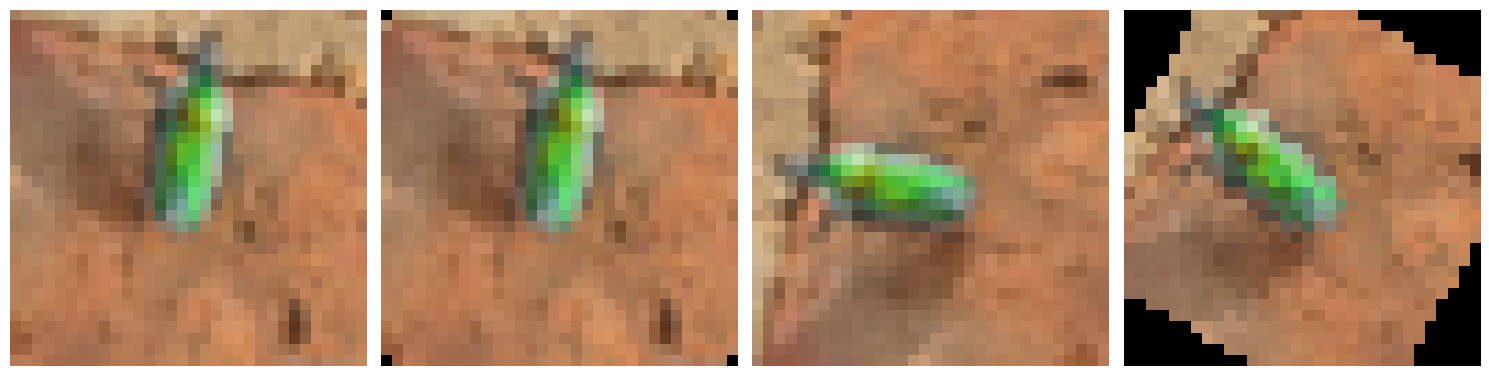

brightness


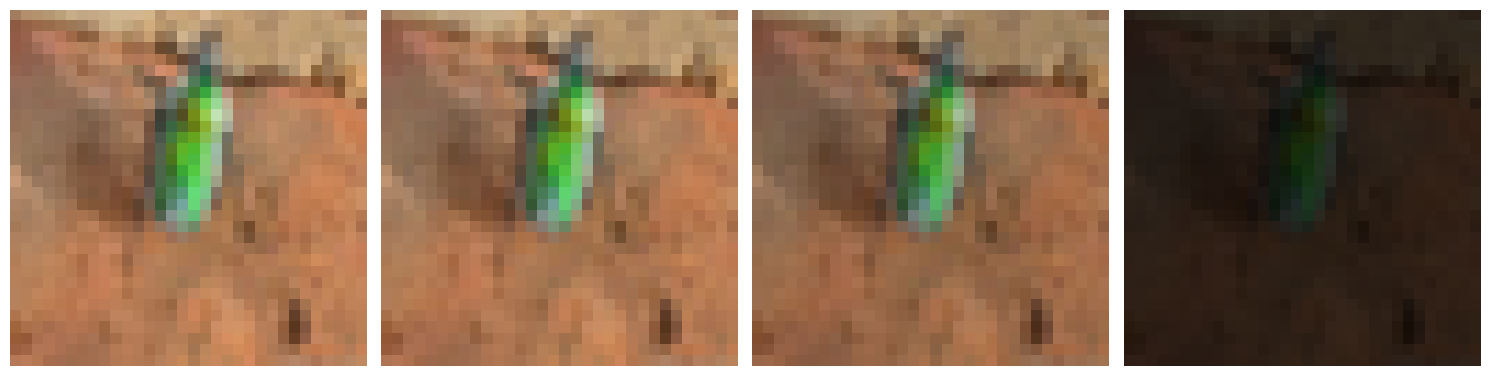

noise


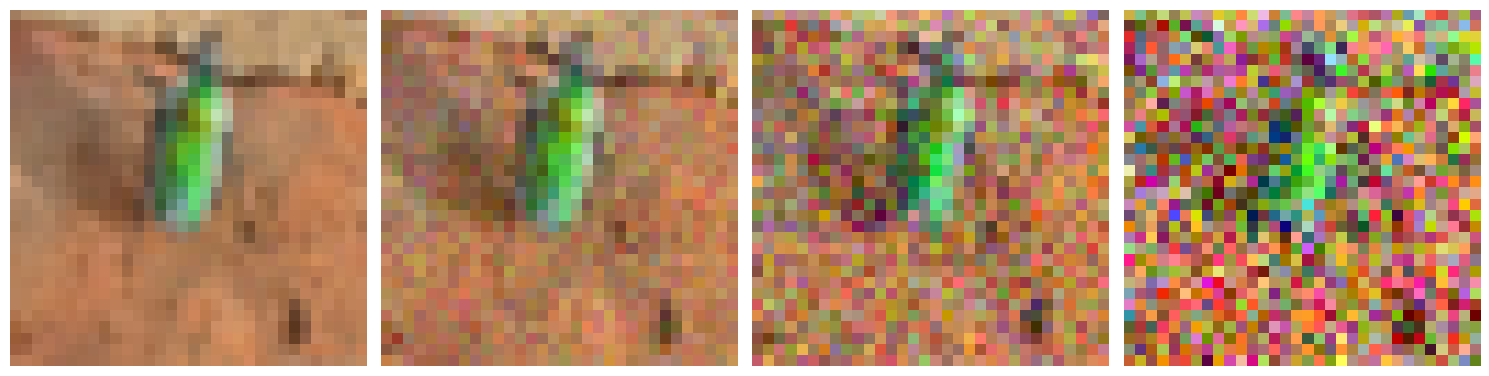

blur


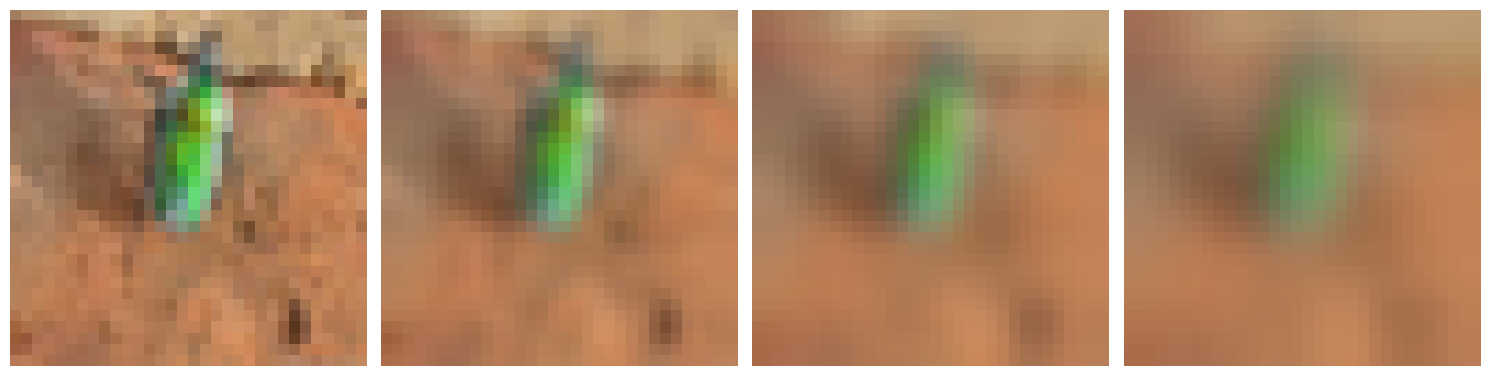

In [8]:
# Get 25 sample images
original_images = it.get_sample_images_from_cifar100(25)

# Display original images
h,w = 2,3
it.display_image_grid(original_images[:h*w],h,w)

# Create transformed dataset
transformed_dataset = it.create_transformation_dataset(original_images)

# Display transformed images
for transformation_name, transformed_images in transformed_dataset.items():
    print(transformation_name)
    it.display_image_grid(transformed_images[:4],1,4)

### testing embedding functions

In [9]:
num_examples = min(10 , len(original_images))
embd_time = emb_funcs.measure_embedding_times(original_images, embedding_functions, num_examples)
for key, value in embd_time.items():
    print(f"Time: {round(value , 5)}s\tFunction: {key}")
    # print("For function :", key,"the time is: " + str(round(value , 5)) + " seconds" if value < num_examples else "was over " + str(num_examples) + " seconds")

Time: 0.007s	Function: simple_color_histogram_embedding
Time: 0.25901s	Function: texture_embedding
Time: 0.0s	Function: composition_rules_embedding
Time: 0.007s	Function: scene_complexity_embedding
Time: 0.0s	Function: downsample_embedding
Time: 0.00599s	Function: edge_histogram_embedding
Time: 0.00101s	Function: fft_embedding
Time: 0.00899s	Function: sift_embedding
Time: 6.55318s	Function: cnn_embedding
Time: 1.80169s	Function: resnet18_embedding
Time: 10.9219s	Function: object_composition_embedding
Time: 10.99552s	Function: semantic_concept_embedding
Time: 0.28545s	Function: color_palette_embedding


#### Remove embedding functions labeled too slow

In [10]:
good_embedding_functions ={}
too_slow = [key for key in embd_time.keys() if embd_time[key] > 0.03]
print(too_slow)

# use results on my machine for stability
too_slow = [ 'cnn_embedding',
             'object_composition_embedding',
             'semantic_concept_embedding',
             'resnet18_embedding',
             'texture_embedding',
             'color_palette_embedding']

for key in embedding_functions:
    if key not in too_slow:
        good_embedding_functions[key] = embedding_functions[key]

['texture_embedding', 'cnn_embedding', 'resnet18_embedding', 'object_composition_embedding', 'semantic_concept_embedding', 'color_palette_embedding']


In [12]:
comprehensive_results = emb_funcs.comprehensive_embedding_analysis(transformed_dataset, good_embedding_functions)


===== Embedding Analysis Results =====

simple_color_histogram_embedding Embedding Analysis:
  rotation:
    Mean Score: 9.3926
    Std Dev:    0.2055
  brightness:
    Mean Score: 7.8817
    Std Dev:    0.8875
  noise:
    Mean Score: 9.3896
    Std Dev:    0.2286
  blur:
    Mean Score: 9.6327
    Std Dev:    0.1235

composition_rules_embedding Embedding Analysis:
  rotation:
    Mean Score: 7.7673
    Std Dev:    0.7261
  brightness:
    Mean Score: 9.6076
    Std Dev:    0.0874
  noise:
    Mean Score: 9.4350
    Std Dev:    0.2737
  blur:
    Mean Score: 9.4451
    Std Dev:    0.3573

scene_complexity_embedding Embedding Analysis:
  rotation:
    Mean Score: 9.1074
    Std Dev:    0.2730
  brightness:
    Mean Score: 7.0179
    Std Dev:    1.2108
  noise:
    Mean Score: 8.4827
    Std Dev:    0.5053
  blur:
    Mean Score: 7.9970
    Std Dev:    1.0758

downsample_embedding Embedding Analysis:
  rotation:
    Mean Score: 8.2970
    Std Dev:    0.7831
  brightness:
    Mean Score

#### Remove embeddings that fail basic similarity test

In [13]:
low_score = [key for key in comprehensive_results if sum([comprehensive_results[key][k]["mean_score"] for k in comprehensive_results[key]]) < 30]
print(low_score)

# use results on my machine for stability
low_score = [ "fft_embedding"]

for key in low_score:
    good_embedding_functions.pop(key)

['fft_embedding']


## Testing with larger Dataset image-net-200

C:\Users\hunte\OneDrive - Technion\ו2\מעבדה בניתוח והצגת נתונים 94295\Project\testing_imagenet.py:86: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = tf.keras.applications.MobileNetV2(


Loading dataset...



00%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

Finding similar pairs...


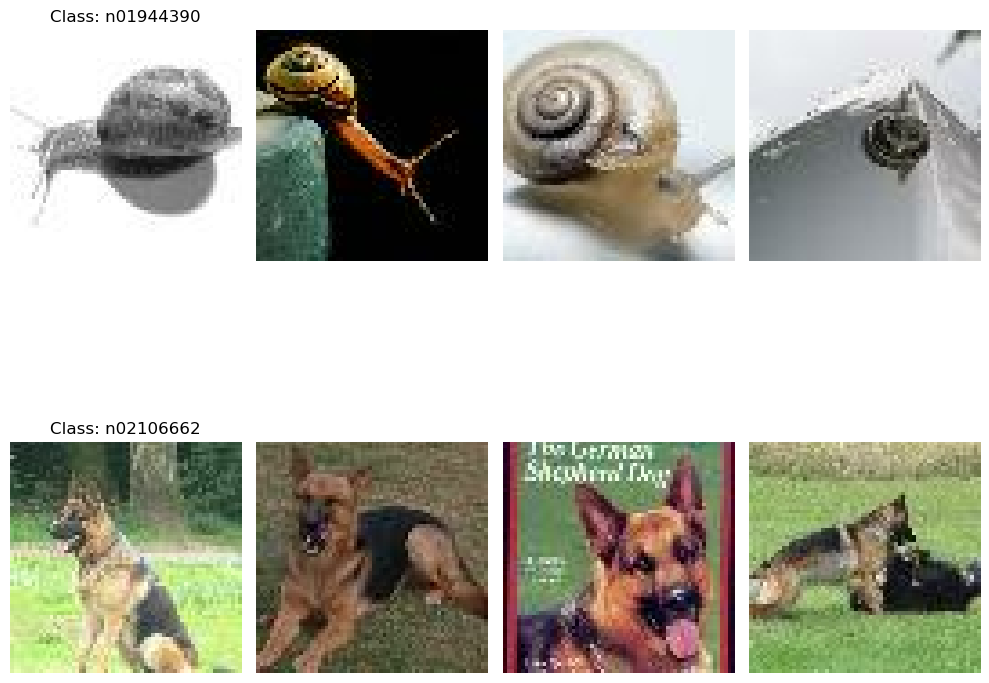

In [14]:
# Get 3 pairs of similar images (6 images total)
images, class_names = ti.get_similar_image_pairs_tiny(2 ,pair_size =4)

# Visualize the pairs with their class names
ti.visualize_tiny_imagenet_pairs(images, class_names , pair_size =4 )

In [15]:
numer_of_images_per_class = 16 # todo make this very big
number_of_classes_from_tiny = 200

In [16]:
#start wrrapers that need class_ids
class_ids =[i for i in range(number_of_classes_from_tiny) for _ in range(numer_of_images_per_class) ]
methods_list["learn_class_weights"] = mm_ann.wrapper_learn_class_weights(class_ids)

In [17]:
pair_similar_images, class_names = ti.get_similar_image_pairs_tiny(number_of_classes_from_tiny ,pair_size = numer_of_images_per_class)

Loading dataset...



00%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:37<00:00,  2.29s/it]

Finding similar pairs...


## applying embedding to large dataset

In [18]:
def get_all_embedings(image , embedding_functions = good_embedding_functions):
    return [ ef(image) for ef in embedding_functions.values()]

In [23]:
start_time = time.time()
pair_sample_embd = [get_all_embedings(i) for i in tqdm(pair_similar_images)]
print(time.time() - start_time)

100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:27<00:00, 116.74it/s]

27.420457363128662


## Evaluating the ANN functions

### Reverify embbeding quality over large dataset

In [25]:
compare_subset_methods = {}
simple_func = methods_list["hnsw_simple_concatenation"]
compare_subset_methods["concat all"] = simple_func
for i , name in enumerate(good_embedding_functions):
    compare_subset_methods["just_"+name]= mm_ann.limit_ann_functions_wrapper(simple_func,[i])
evann.evaluate_ann_search(pair_sample_embd , compare_subset_methods , num_searches= 100 , pair_size= numer_of_images_per_class,K= 18 ,display= False )

,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,concat all,0.052427,0.042877,0.00010,0.015000,0.018000
1,just_simple_color_histogram_embedding,0.064077,0.022001,0.00007,0.018333,0.022000
2,just_composition_rules_embedding,0.036893,0.014001,0.00007,0.010556,0.012667
3,just_scene_complexity_embedding,0.044660,0.013001,0.00005,0.012778,0.015333
4,just_downsample_embedding,0.058252,0.022000,0.00014,0.016667,0.020000
5,just_edge_histogram_embedding,0.046601,0.018001,0.00008,0.013333,0.016000
6,just_sift_embedding,0.042718,0.020002,0.00010,0.012222,0.014667


## Results

In [26]:
evann.evaluate_ann_search(pair_sample_embd , methods_list , num_searches= 200 , pair_size= numer_of_images_per_class,K= numer_of_images_per_class ,display= False )

during the training process of learn_class , found the weights for each embedding are [1.247924286043917, 1.1558234053943381, 1.3011688735740896, 0.8172417959330276, 0.6367929519621262, 0.8410486870925007]


,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,hnsw_simple_concatenation,0.058106,0.048998,0.000140,0.017188,0.018333
1,LSH_simple_concatenation,0.047542,0.045498,0.000155,0.014063,0.015000
2,separate indexing,0.073953,0.094001,0.002223,0.021875,0.023333
3,Split LSH,0.015847,0.037915,0.000376,0.004687,0.005000
4,just norm,0.062332,0.095002,0.003458,0.018437,0.019667
5,Normalized and Scaled,0.070784,0.132921,0.000325,0.020938,0.022333
6,Dimension Reduction,0.055993,0.115996,0.000158,0.016563,0.017667
7,robust multi index,0.077123,0.092524,0.143619,0.022812,0.024333
8,Capped Distance,0.064445,0.016001,0.004359,0.019062,0.020333
9,Tolerant ANN,0.039090,0.289359,0.000810,0.011562,0.012333


## comapre to renet-18

In [29]:
print("Remainder: the embedding functions used are")
summ = 0
for name in good_embedding_functions.keys():
    print("For function: ", name," with embedding time of: ", round(embd_time[name], 5), "seconds")
    summ += embd_time[name]

print()
res_func = {"resnet18_embedding": emb_funcs.resnet18_embedding}
resnet_restime = emb_funcs.measure_embedding_times(original_images, res_func, num_examples)
print("for resnet18 embedding time of:", round(list(resnet_restime.values())[0], 5), "seconds")
print("all other functions had a total embedding time of:", round(summ, 5), "seconds")

Remainder: the embedding functions used are
For function:  simple_color_histogram_embedding  with embedding time of:  0.007 seconds
For function:  composition_rules_embedding  with embedding time of:  0.0 seconds
For function:  scene_complexity_embedding  with embedding time of:  0.007 seconds
For function:  downsample_embedding  with embedding time of:  0.0 seconds
For function:  edge_histogram_embedding  with embedding time of:  0.00599 seconds
For function:  sift_embedding  with embedding time of:  0.00899 seconds

for resnet18 embedding time of: 1.86114 seconds
all other functions had a total embedding time of: 0.02899 seconds


In [32]:
#limit_size = numer_of_images_per_class*100
embd_res = [get_all_embedings(i, res_func) for i in tqdm(pair_similar_images)]#[:limit_size]]
embd_other = pair_sample_embd #[:limit_size]


00%|██████████████████████████████████████████████████████████████████████████████| 3200/3200 [10:22<00:00,  5.14it/s]

In [34]:
print(evann.evaluate_ann_search(embd_res , {"resnet-18":methods_list["hnsw_simple_concatenation"]} , num_searches= 200 , pair_size= numer_of_images_per_class,K= numer_of_images_per_class ,display= False ))
#todo change methods_list["hnsw_simple_concatenation"] to best methods
print(evann.evaluate_ann_search(embd_other , {"other embeddings concat ":methods_list["hnsw_simple_concatenation"],"using capped distance":methods_list["Capped Distance"]} , num_searches= 200 , pair_size= numer_of_images_per_class,K= numer_of_images_per_class ,display= False ))

  Method Name  Mean Average Precision@K  Index Build Time  \
0   resnet-18                  0.073953           0.02548   

   Average Search Time  Accuracy@K  Recall@K  
0             0.000105    0.021875  0.023333  
                Method Name  Mean Average Precision@K  Index Build Time  \
0  other embeddings concat                   0.058106          0.055700   
1     using capped distance                  0.064445          0.033858   

   Average Search Time  Accuracy@K  Recall@K  
0             0.000115    0.017188  0.018333  
1             0.004675    0.019062  0.020333  
